#### For MFC first convert normal frequency to MEL SCALE(kinda like perceived by human ear) then make different bins and calculate the energy use MEL FREQUENCY BINS, these are smaller near 0 Hz and increase as we go towards higher frequencies because thats how human ears perceive noise. Then take the DCT.  Here I am taking the first 40 MFCCs. MFCCs are state-of-the-art ever since their inception.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import librosa
import librosa.display   #Now its necessary to import it
from IPython.display import Audio
import os

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train.all()    #No Null Objects

ID       False
Class     True
dtype: bool

In [5]:
test.all() #No Null Objects

ID    True
dtype: bool

In [6]:
train.head(10)

ID             Class
0   0             siren
1   1      street_music
2   2          drilling
3   3             siren
4   4          dog_bark
5   6  children_playing
6  10      street_music
7  11          drilling
8  12          gun_shot
9  15          dog_bark

In [7]:
test.head(10)

ID
0   5
1   7
2   8
3   9
4  13
5  14
6  16
7  21
8  23
9  25

In [8]:
data, sr = librosa.load('Train/0.wav')

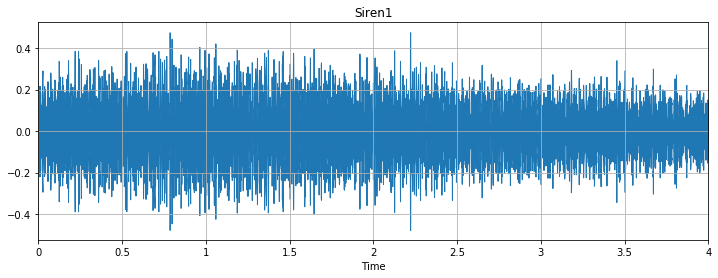

In [9]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr)
plt.grid()
plt.title('Siren1')
plt.show()

In [10]:
data, sr = librosa.load('Train/3.wav')

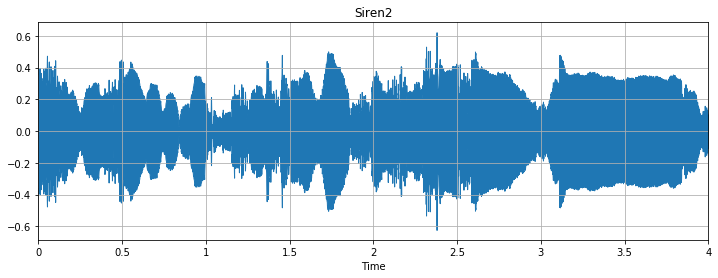

In [11]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr)
plt.title('Siren2')
plt.grid()
plt.show()

In [12]:
Audio('Train/0.wav')

In [13]:
Audio('Train/3.wav')

In [14]:
data, sr = librosa.load('Train/1.wav')

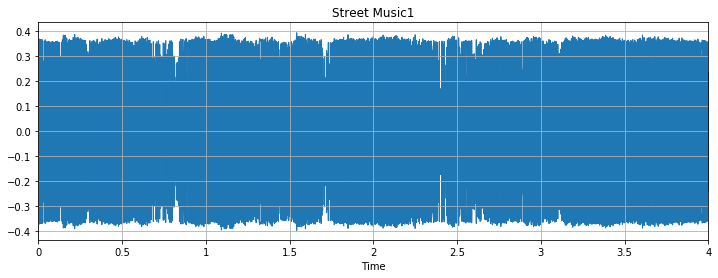

In [15]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr)
plt.title('Street Music1')
plt.grid()
plt.show()

In [16]:
data, sr = librosa.load('Train/10.wav')

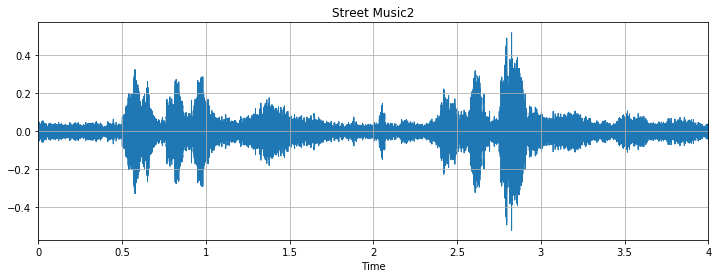

In [17]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr)
plt.title('Street Music2')
plt.grid()
plt.show()

In [18]:
Audio('Train/10.wav')

In [19]:
data, sr = librosa.load('Train/4.wav')

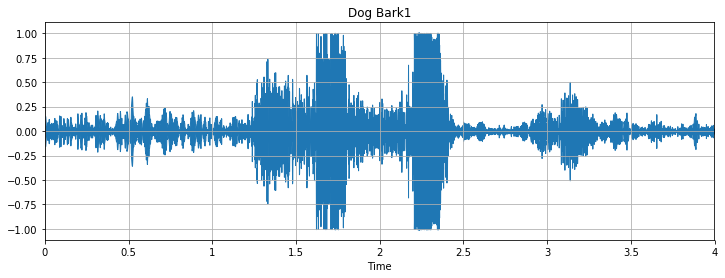

In [20]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr)
plt.title('Dog Bark1')
plt.grid()
plt.show()

In [21]:
Audio('Train/4.wav')

In [22]:
data, sr = librosa.load('Train/15.wav')

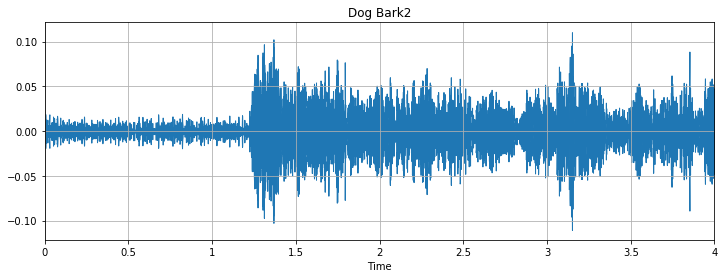

In [23]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr)
plt.title('Dog Bark2')
plt.grid()
plt.show()

In [24]:
Audio('Train/15.wav')

In [25]:
train.Class.value_counts(normalize = True)   #Total data for each Class in train

jackhammer          0.122907
engine_idling       0.114811
siren               0.111684
dog_bark            0.110396
street_music        0.110396
drilling            0.110396
air_conditioner     0.110396
children_playing    0.110396
car_horn            0.056302
gun_shot            0.042318
Name: Class, dtype: float64

#### DUMBEST MODEL ACCURACY = 12.2907, This is the benchmark model! i.e. we will predict every sound is that of a jackhammer.

In [26]:
def parser(row):
    # function to load files and extract features
    #optimised for any OS like for eg WINDOWS uses '\' whereas linux uses '/'
    file_path = os.path.join('Train', str(row.ID) + '.wav')

    # handle exception to check if there isn't a file which is corrupted
    try:
    # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        # we extract mfcc feature from data
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        print("Error encountered while parsing file: ",row.ID)
        return None, None
 
    feature = mfccs
    label = row.Class
 
    return [feature, label]


In [27]:
temp = train.apply(parser, axis=1)
temp.columns = ['feature', 'label']

Error encountered while parsing file:  3190


###### as is clear from above the file 3190.wav has some problem.. eversince its an audio file lets see what it might be

In [28]:
Audio('Train/3190.wav')

## Now we need to perform tokenization after all you can't feed literally 'sound' into your Deep Learning model ;)

In [29]:
from sklearn.preprocessing import LabelEncoder 
from keras.utils import np_utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


##### To perform tokenization we first convert the sound data to a NUMPY ARRAY

In [30]:
# okay now
temp.label.hasnans

True

##### Hell it has nans, hence the label encoder is not capable to fit because internally it uses some NUMPY fucntions like max() which are NOT
##### campatible with it hence we gotta drop them off!

In [31]:
temp.label.dropna(how = 'any', inplace = True)   #yippe all removed but I didnt inplace = True yet sot
# BUT GOTTA DROP CORRESPONDING IN temp

In [32]:
temp.feature.drop(index = 1986, inplace = True)

In [33]:
temp.feature.shape

(5434,)

In [34]:
temp.label.size

5434

In [35]:
temp.label.count()

5434

###### so ony one guy is MISBEHAVING we gotta kick him off, ALSO REMEMBER THAT np.nan != np.nan or pd.np.nan != pd.np.nan
###### so you can't easily find out!!!!!

In [36]:
pd.isnull(temp).any(1).nonzero()[0]  # THIS SI OUR SCUMBAG!!! LETS KICK HIM OFF FROM BOTH THE SERIES!

array([1986])

In [62]:
x = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist()) #tolist() not necessary and I guess u may use ravel() as well <3

In [63]:
lb = LabelEncoder()  # we can use this lb to transform the data-set we wanna test.

In [ ]:
## Now we're gonna fit_transform() our data means calculate MU and SIGMA, then transform accordingly.

In [66]:
y_transformed = lb.fit_transform(y)

In [67]:
y_transformed

array([8, 9, 4, ..., 5, 5, 0])

In [68]:
#now we gotta convert it to ONE-HOT VECTOR ENCODING
#i.e. if you have [1,3,5]so ONE-HOT ENCODING IS 
# total size =6 because it converts the value to indice
#[0 1 0 0 0 0] for 1
#[0 0 0 1 0 0] for 3
#[0 0 0 0 0 0] for 5

In [69]:
uniques, indices = np.unique(y_transformed, return_inverse=True)

In [70]:
uniques  # see all the labels are converted to numeric labels by fit_transform

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [71]:
y_one_hot_encoded = np_utils.to_categorical(indices, len(uniques))

In [72]:
y_one_hot_encoded

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [73]:
#uniques[y_one_hot_encoded.argmax(1)]   # we got the y_transformed back!!

array([8, 9, 4, ..., 5, 5, 0])

In [75]:
#y_back = lb.inverse_transform(y_transformed) # we got y back

/home/headh/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [76]:
#y_back   #we got y back

array(['siren', 'street_music', 'drilling', ..., 'engine_idling',
       'engine_idling', 'air_conditioner'], dtype='<U16')

In [39]:
y = np_utils.to_categorical(lb.fit_transform(y))

###### ok so basically now fit_transform tokenized y and since it had labels so values will be repeated I could have also if wanted could have first called for fit() and then transform() but this is easy, NOW to convert testing data we will use just the transform() function! also finally the NP_UTILS.TO_CATEGORICAL() function converts it into ONE HOT VECTOR FORM!

### DEEP LEARNING MODEL HERE-ON

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [79]:
number_of_labels = y_one_hot_encoded.shape[1]

In [48]:
#Building model Sequentially i.e. layer by layer
model = Sequential()
model.add(Dense(256, activation = 'tanh', input_dim = 40))  #we took 40 MFCC
model.add(Dropout(0.5))
model.add(Dense(256,activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(number_of_labels, activation='softmax'))   #takes out the PROBABLITY DISTRIBUTION! <3


In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               10496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 78,858
Trainable params: 78,858
Non-trainable params: 0
_________________________________________________________________


In [50]:
#COmpile the model <3
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [51]:
model.fit(x, y, epochs=50, validation_split = 0.2, verbose=1)  #split 20% for validation <3

Train on 4347 samples, validate on 1087 samples
Epoch 1/50
4347/4347 [==============================] - 1s 132us/step - loss: 2.3045 - acc: 0.2593 - val_loss: 1.5303 - val_acc: 0.4618
Epoch 2/50
4347/4347 [==============================] - 0s 107us/step - loss: 1.8316 - acc: 0.3734 - val_loss: 1.3970 - val_acc: 0.5317
Epoch 3/50
4347/4347 [==============================] - 1s 117us/step - loss: 1.6122 - acc: 0.4576 - val_loss: 1.2423 - val_acc: 0.5961
Epoch 4/50
4347/4347 [==============================] - 1s 118us/step - loss: 1.5153 - acc: 0.4819 - val_loss: 1.1784 - val_acc: 0.6099
Epoch 5/50
4347/4347 [==============================] - 0s 110us/step - loss: 1.3746 - acc: 0.5342 - val_loss: 1.0807 - val_acc: 0.6532
Epoch 6/50
4347/4347 [==============================] - 0s 106us/step - loss: 1.3257 - acc: 0.5546 - val_loss: 1.0376 - val_acc: 0.6661
Epoch 7/50
4347/4347 [==============================] - 0s 109us/step - loss: 1.2844 - acc: 0.5666 - val_loss: 0.9811 - val_acc: 0.6946


### Okay so to invert fit_transform() [when calculating MU and SIGMA from data the TRANSFORMING ACCORDINGLY, alter = first call fit() and then transform()]  OR transform() [in case when we are validation our data from a test set] use inverse_transform() to get it back ofcourse you gotta use as 
### lb.fit_transform() // lb.fit()  lb.transform() // lb.transform() AND THEN
### lb.inverse_transform()  
### DOCUMENTATION :  http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html